## Importing Libraries

In [1]:
from __future__ import print_function
from pprint import pprint
from time import time
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
%matplotlib inline #to plot automatically
plt.style.use('bmh')

### Importing sklearn modules
___

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, confusion_matrix

### Preprocessing Data
___
This function preprocess our dataset:
- TF-IDF, is used to represent the importance of the words inside their context
- SPLIT, is used to split the dataset into two portions defined by RATIO of **training** and **testing**

The stratify parameter is used to balance the distribution of training and testing set over all the classes.

In [ ]:
def preprocess_data(data, vectorizer, ratio=0.9):
    '''
    Function used to preprocess the dataset, vectorize, and split it in training and testing portions.
    Params:
        @data: the dataset that will be split and vectorized
        @vectorizer: used to vectorize the data
        @ratio: the ratio used to split the dataset
    '''
    X = vectorizer.fit_transform(data.data)
    return train_test_split(X, data.target, test_size=1-ratio, random_state=0, stratify=data.target)

### Coarse-to-fine approach for hyper parameters optimization
To find the best parameters is commonly used a coarse-to-fine approach.
We first start with a wide range of parameters and we refine them as we get closer to the best results.
___
We declare the parameters we want to optimize:
- More parameters =  better exploring power 
- Less parameters = decreasing processing time

In the GridSearchCV function is possible to choose several parameters, in particular:
- **n_jobs**, are the threads used in the computations
- **verbose**, will show in verbose mode the output of the training
- **cv**, it's possible to specify how many folds to use in the cross validation
- **scoring**, the metric used for the training.

While the first parameters will not impact so much in the effective accuracy of the classifier, it's important to define a good scoring metric.

In our classification problem we need to maximize the number of samples that we correctly predict. For this reason we need to have a scoring metrics that focuses on the number of correct samples predicted over the total.
After this reasoning we choose to select the *'accuracy'* metric, which is the scoring metric the does what we need.

In [4]:
def estimate_parameters(train_X, train_Y, pipeline, parameters, n_jobs=4, verbose=1, cv=5):
    '''
    Function used to optimize parameters of the RandomForest using GridSearchCV.
    Params:
        @train_X: features dataset of training
        @train_Y: label dataset of training
        @pipeline: the parameters that are optimized 
        @parameters: the parameters ranges used for the optimization
        @n_jobs, used to parallelize the training.
        @verbose, output training in verbose mode.
        @cv, k-fold used.
    '''
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=n_jobs, verbose=verbose, cv=cv, scoring='accuracy')
    print('----------------------------------------')
    print("Cross validating with grid search for...")
    print([name for name, _ in pipeline.steps])
    print('----------------------------------------')
    print("Analyzed parameters:")
    pprint(parameters)
    print('----------------------------------------')
    t0 = time()
    grid_search.fit(train_X, train_Y)
    print("Fine tuning took %0.3fs" % (time() - t0))
    print("Best obtained is score: %0.3f" % grid_search.best_score_)
    best_estimator = grid_search.best_estimator_
    # print("Grid score results")
    # print(grid_search.cv_results_) # USED TO SEE THE RESULTS OF EVERY PARAMETERS COMBINATION
    return best_estimator

### Training Random Forest classifier
___
We build the Random Forest classifier specifying:
- number of estimators
- maximum depth of the forest

We train the model and return the classifier

In [5]:
def train_random_forest(X_train, y_train, n_estimators, max_depth):
    '''
    Function used to train the random forest classifier.
    Params:
        @train_X: features dataset of training
        @train_Y: label dataset of training
        @n_estimators: number of estimators in the random forest
        @max_depth: max depth of the random forest
    '''
    rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    return rfc.fit(X_train, y_train)

### Plotting confusion matrix

We plot the confusion matrix of our classifier given the classes names.
__

In [6]:
def plot_confusion_matrix(cnf_matrix, class_names):
    '''
    Function used to plot the confusion matrix of the classified prediction.
    Params:
        @cnf_matrix: confusion matri of the prediction
        @class_names: label names
    '''
    norm_conf = []
    for i in cnf_matrix:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            tmp_arr.append(float(j)/float(a))
        norm_conf.append(tmp_arr)
    fig = plt.figure(figsize=(16, 10))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                    interpolation='nearest')
    width, height = cnf_matrix.shape
    for x in range(width):
        for y in range(height):
            ax.annotate(str(cnf_matrix[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    cb = fig.colorbar(res)
    plt.xticks(range(width), class_names, rotation=90)
    plt.ylabel('True Label')
    plt.xlabel('Prediction Label')
    plt.yticks(range(height), class_names)

### Visualize importance of features and the distribution of the importance

In [7]:
def visualize_features_importance(classifier, n_features=50, y='Feature importance'):
    '''
    Function used to plot the confusion matrix of the classified prediction.
    Params:
        @classifier: random forest classifier
        @n_features: number of features to show
        @y: label for the features importance - 'Feature Importance' by default
    '''
    importances_feat = pd.DataFrame(classifier.feature_importances_)
    importances_feat.columns = [y]
    importances_feat = importances_feat.sort_values(y,ascending=False)
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[16,10])
    plt.suptitle('Distribution of feature importance', x=0.5, y=1.00, ha='center', fontsize='xx-large')
    importances_feat.head(n_features).hist(ax=axes[0])
    importances_feat.head(n_features).plot(ax=axes[1],kind='bar', title='Importance of the features')
    return importances_feat

## Execution
___
Fetching dataset and preprocessing using the functions described above.

In [8]:
data = fetch_20newsgroups(subset='all')
vectorizer = TfidfVectorizer()

### Analyzing the dataset
First thing we print the keys of the data, to check what are the columns that we're interested in.

In [9]:
data.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])

We create a frame to analyze its structure and then we print its content.

In [10]:
df = pd.DataFrame(data={'document':data['data'], 'category':data['target']})

In [11]:
pd.set_option('display.max_colwidth', -1)
df.head()

,category,document
0,10,"From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>\nSubject: Pens fans reactions\nOrganization: Post Office, Carnegie Mellon, Pittsburgh, PA\nLines: 12\nNNTP-Posting-Host: po4.andrew.cmu.edu\n\n\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game. PENS RULE!!!\n\n"
1,3,"From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)\nSubject: Which high-performance VLB video card?\nSummary: Seek recommendations for VLB video card\nNntp-Posting-Host: midway.ecn.uoknor.edu\nOrganization: Engineering Computer Network, University of Oklahoma, Norman, OK, USA\nKeywords: orchid, stealth, vlb\nLines: 21\n\n My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM. Does anyone have suggestions/ideas on:\n\n - Diamond Stealth Pro Local Bus\n\n - Orchid Farenheit 1280\n\n - ATI Graphics Ultra Pro\n\n - Any other high-performance VLB card\n\n\nPlease post or email. Thank you!\n\n - Matt\n\n-- \n | Matthew B. Lawson <------------> (mblawson@essex.ecn.uoknor.edu) | \n --+-- ""Now I, Nebuchadnezzar, praise and exalt and glorify the King --+-- \n | of heaven, because everything he does is right and all his ways | \n | are just."" - Nebuchadnezzar, king of Babylon, 562 B.C. | \n"
2,17,"From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject: Re: ARMENIA SAYS IT COULD SHOOT DOWN TURKISH PLANES (Henrik)\nLines: 95\nNntp-Posting-Host: viktoria.dsv.su.se\nReply-To: hilmi-er@dsv.su.se (Hilmi Eren)\nOrganization: Dept. of Computer and Systems Sciences, Stockholm University\n\n\n\n\n|>The student of ""regional killings"" alias Davidian (not the Davidian religios sect) writes:\n\n\n|>Greater Armenia would stretch from Karabakh, to the Black Sea, to the\n|>Mediterranean, so if you use the term ""Greater Armenia"" use it with care.\n\n\n\tFinally you said what you dream about. Mediterranean???? That was new....\n\tThe area will be ""greater"" after some years, like your ""holocaust"" numbers......\n\n\n\n\n|>It has always been up to the Azeris to end their announced winning of Karabakh \n|>by removing the Armenians! When the president of Azerbaijan, Elchibey, came to \n|>power last year, he announced he would be be ""swimming in Lake Sevan [in \n|>Armeniaxn] by July"".\n\t\t*****\n\tIs't July in USA now????? Here in Sweden it's April and still cold.\n\tOr have you changed your calendar???\n\n\n|>Well, he was wrong! If Elchibey is going to shell the \n|>Armenians of Karabakh from Aghdam, his people will pay the price! If Elchibey \n\t\t\t\t\t\t ****************\n|>is going to shell Karabakh from Fizuli his people will pay the price! If \n\t\t\t\t\t\t ******************\n|>Elchibey thinks he can get away with bombing Armenia from the hills of \n|>Kelbajar, his people will pay the price. \n\t\t\t ***************\n\n\n\tNOTHING OF THE MENTIONED IS TRUE, BUT LET SAY IT's TRUE.\n\t\n\tSHALL THE AZERI WOMEN AND CHILDREN GOING TO PAY THE PRICE WITH\n\t\t\t\t\t\t **************\n\tBEING RAPED, KILLED AND TORTURED BY THE ARMENIANS??????????\n\t\n\tHAVE YOU HEARDED SOMETHING CALLED: ""GENEVA CONVENTION""???????\n\tYOU FACIST!!!!!\n\n\n\n\tOhhh i forgot, this is how Armenians fight, nobody has forgot\n\tyou killings, rapings and torture against the Kurds and Turks once\n\tupon a time!\n \n \n\n|>And anyway, this ""60 \n|>Kurd refugee"" story, as have other stories, are simp

### Splitting dataset
To train our Random Forest classifier we would like to split our dataset in a portion of training and testing. We are not splitting it in another portion for validation since the function **GridSearchCV** given by **Scikit-learn** takes care of the validation part (with the possibility to specify the number of folds _k_).

We specify the ratio the we use to split the dataset and the vectorizer used to parse the documents (in our case a TF-IDF Vectorizer).

In [12]:
X_train, X_test, y_train, y_test = preprocess_data(data, vectorizer, 0.9)

#### Pipeline and Parameters declaration
___
- TfidfVectorizer is our TF-IDF vectorizer for the sentences
- RandomForestClassifier is the classifier we are training

Note:
For further analysis it is possible to specify parameters also for the TfidfVectorizer, considering always that more parameters means more exploration power but more computation time also.

In [13]:
# Define a Pipeline
pipeline = Pipeline([
    #('vect', TfidfVectorizer()),
    ('clf', RandomForestClassifier()),
])

### Parameters fine-tuning
___
Now we try to optimize our model by selecting a range for our parameters:
- **max_depth**: between 20 and 40
- **n_estimators**: between 300 and 500

As we have seen so far, those are the most reasonable values for each parameters. We now run the GridSearchCV to optimize them and search for the best ones.

In [14]:
parameters = {
    'clf__max_depth': (20, 30, 40),
    'clf__n_estimators': (300, 400, 500),
}

In [15]:
best_estimator = estimate_parameters(X_train, y_train, pipeline, parameters)

----------------------------------------
Cross validating with grid search for...
['clf']
----------------------------------------
Analyzed parameters:
{'clf__max_depth': (20, 30, 40), 'clf__n_estimators': (300, 400, 500)}
----------------------------------------
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 14.8min
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed: 44.1min finished


Fine tuning took 2847.081s
Best obtained is score: 0.836


In [16]:
best_estimator

Pipeline(memory=None,
     steps=[('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

### Trade-off - Performance vs Accuracy
As we can see from the previous testing, the best results are obtained with the highest values of our parameters.
So, we decide to increase the value of estimators and the max depth of the forest to see if we obtain better results without impacting to much on the performances.

For the next testing:
- **max_depth**: between 40 and 60
- **n_estimators**: between 500 and 1000

In [17]:
parameters = {
    'clf__max_depth': (40, 50, 60),
    'clf__n_estimators': (500, 800, 1000),
}

In [18]:
best_estimator = estimate_parameters(X_train, y_train, pipeline, parameters)

----------------------------------------
Cross validating with grid search for...
['clf']
----------------------------------------
Analyzed parameters:
{'clf__max_depth': (40, 50, 60), 'clf__n_estimators': (500, 800, 1000)}
----------------------------------------
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 55.1min
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed: 148.9min finished


Fine tuning took 9526.244s
Best obtained is score: 0.853


AttributeError: 'Pipeline' object has no attribute 'best_parameters'

In [19]:
best_estimator

Pipeline(memory=None,
     steps=[('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=60, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

### Observations on the parameters optimization
Like the first time we obtain the best results with the highest values. This time the computation took a big amount of time. For this reason we will not explore other values since as we can notice we are already loosing in terms of performance without having a significant bonus in the accuracy.

### Training
We train the RandomForest classifier with the best parameters obtained after our cross validation to predict the category of each news email. 

In [20]:
params = best_estimator.get_params()

In [21]:
classifier = train_random_forest(X_train, y_train, 
                    params.get('clf__n_estimators'), 
                    params.get('clf__max_depth'))

### Testing

We test the classifier with the test set that we splitted before.

In [22]:
classifier.score(X_test, y_test)

0.84827586206896555

### Plotting confusion Matrix

We plot the confusion matrix

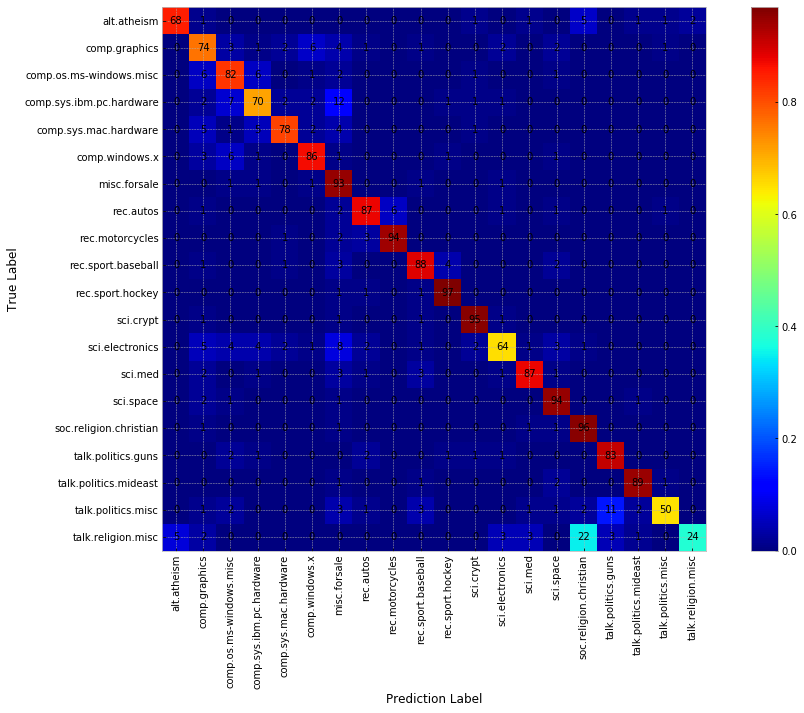

In [23]:
y_pred = classifier.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names = data.target_names
plot_confusion_matrix(cnf_matrix, class_names)

#### Observations:
As we can see from the confusion matrix some of the categories are quite related, and this is why sometimes our classifier is not accurate. For instance **sci.electronics** is sometimes interpreted a **msc.forsale** which is intuitively right.
The most evident category that we see is misunderstood is **talk.religion.misc**, which is often classified as **soc.religion.christian**, in fact both share common topics.

We can state that our classifier performs well, however it still has some problems while trying to classify topic-related documents. In fact, the TF-IDF vectorizer assings importances to features based on their frequency in the document and their global frequency. This is the reason why our classifier encounters some problems when classifying similar categories.
___
### Plotting features importance and distribution

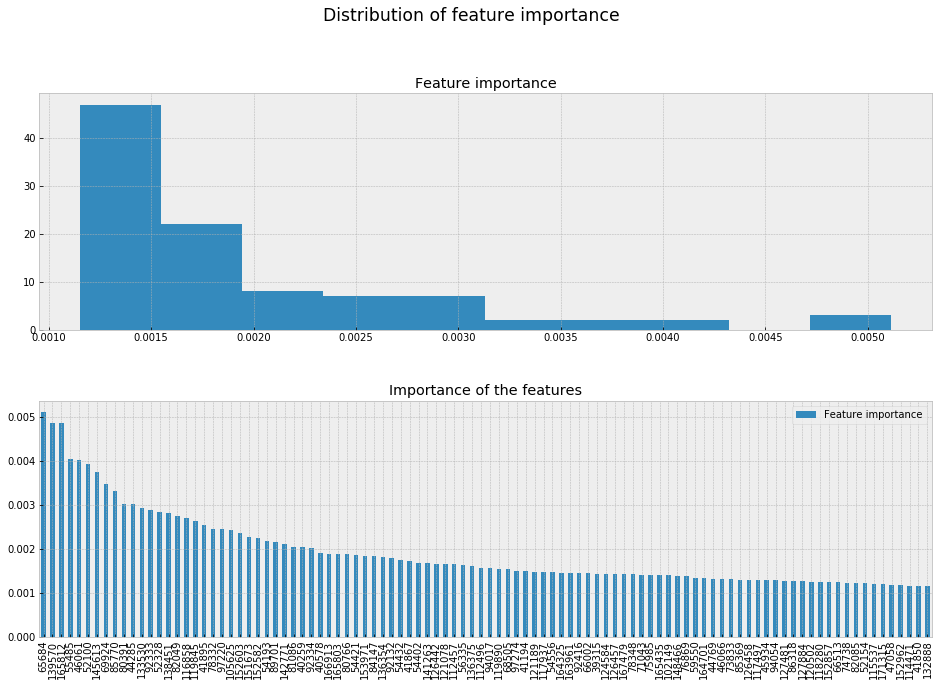

In [24]:
importances_feat = visualize_features_importance(classifier)

#### Description of the feature importance

In [25]:
importances_feat.describe()

,Feature importance
count,1.737620e+05
mean,5.754998e-06
std,6.249687e-05
min,0.000000e+00
25%,0.000000e+00
50%,4.483773e-08
75%,7.706178e-07
max,5.115103e-03


#### Observations:
As we can see from the values in the description above:
- The entire first quartile is useless across all the decision trees.
- The second quartile don't have a big importance.
- The third one is comparable (even if lower) with the mean of the values, and that means that it's important in the process of classification.

Given this results, we can state that this behaviour is reasonable since giving importances to different features instead of giving importance to a small subset can prevent overfitting in a decision tree. Furthermore, both the bar plots above, (the distribution of importance and the importance of each feature) show that the majority of the features (approximately 75%) don't have a big importance. This plot matches our previous assumption given the description of the feature importances.